# Plant Disease Detection of 'PlantDoc' Dataset, using Tensorflow Object Detection API
- dataset from https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset
  - original Pascal VOC annotations cleaned up using `./utils/clean-pascalvoc-annotations.ipynb`
- this notebook is referenced from https://github.com/nicknochnack/TFODCourse


# 0. Setup Paths

In [1]:
import os

CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH':           os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH':             os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH':            os.path.join('Tensorflow', 'models'),
    # 'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    # 'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','images'),
    'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','PlantDoc-Object-Detection-Dataset-master'),
    'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    
    'MODEL_PATH':               os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH':    os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH':          os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':                os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':              os.path.join('Tensorflow', 'protoc')
}

files = {
    'PIPELINE_CONFIG':  os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP':         os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [2]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Install TFOD API

In [3]:
if os.name=='nt':
    !pip install wget
    import wget

In [3]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

### Ad-hoc install additional missing packages until TFOD API working

In [ ]:
# !pip install pytz

In [ ]:
# !pip install pyyaml

In [ ]:
# !pip install --user tensorflow_addons
# !pip install gin-config
# !pip install tf-nightly

### Verify TFOD API working

In [5]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.10.4: c:\Anaconda\envs\tfcv\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-19 16:17:30.295196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 16:17:30.999543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
c:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\model_builder.py:1102: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W091

In [9]:
# import object_detection

# 1.1 Download pre-trained model from TF Model Zoo
- in our case, we are using ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8
- we could download and train multiple models simultaneously, and evaluate trained checkpoints simultaneously to see which model is performing better.

In [4]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

### Manually:

In [ ]:
# labels = [
#     {'id':1, 'name':'axial1', }, 
#     {'id':2, 'name':'axial0', }, 
#     {'id':3, 'name':'coronal1', },
#     {'id':4, 'name':'coronal0', }, 
#     {'id':5, 'name':'sagittal1', }, 
#     {'id':6, 'name':'sagittal0', },
#     ]

### Dataset comes with a csv, so we can use that:

In [5]:
import pandas as pd
train_labels = pd.read_csv(r'D:\code\_projects\_practice\TFODCourse-main\Tensorflow\workspace\PlantDoc-Object-Detection-Dataset-master\train_labels.csv')

In [6]:
classnames = train_labels['class'].unique().tolist()

labels = []
for i, name in enumerate(classnames): 
    labels.append({'id':i+1, 'name':name})

labels

[{'id': 1, 'name': 'Cherry leaf'},
 {'id': 2, 'name': 'Peach leaf'},
 {'id': 3, 'name': 'Corn leaf blight'},
 {'id': 4, 'name': 'Apple rust leaf'},
 {'id': 5, 'name': 'Potato leaf late blight'},
 {'id': 6, 'name': 'Strawberry leaf'},
 {'id': 7, 'name': 'Corn rust leaf'},
 {'id': 8, 'name': 'Tomato leaf late blight'},
 {'id': 9, 'name': 'Tomato mold leaf'},
 {'id': 10, 'name': 'Potato leaf early blight'},
 {'id': 11, 'name': 'Apple leaf'},
 {'id': 12, 'name': 'Tomato leaf yellow virus'},
 {'id': 13, 'name': 'Blueberry leaf'},
 {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 {'id': 15, 'name': 'Raspberry leaf'},
 {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 {'id': 18, 'name': 'grape leaf'},
 {'id': 19, 'name': 'Corn Gray leaf spot'},
 {'id': 20, 'name': 'Tomato Early blight leaf'},
 {'id': 21, 'name': 'Apple Scab Leaf'},
 {'id': 22, 'name': 'Tomato Septoria leaf spot'},
 {'id': 23, 'name': 'Tomato leaf'},
 {'id': 24, 'name': 'Soya

### Save label_map.pbtxt in annotations folder.

In [7]:
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Generate TF records

In [8]:
#### if need to untar dataset
# ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
# if os.path.exists(ARCHIVE_FILES):
#   !tar -zxvf {ARCHIVE_FILES}

### get generate_tfrecord.py, or download it manually:

In [26]:
# if not os.path.exists(files['TF_RECORD_SCRIPT']):
#     !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
#     https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

### run util and generate TFRecords

In [8]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TRAIN')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TEST')}  -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}


Traceback (most recent call last):
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 172, in <module>
    tf.app.run()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\platform\app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 162, in main
    tf_example = create_tf_example(group, path)
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 116, in create_tf_example
    encoded_jpg = fid.read()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 114, in read
    self._preread_check()


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy pre-trained model config to our training folder

In [9]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Customize config for our use case

In [10]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [11]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [12]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [13]:
pipeline_config.model.ssd.loss.classification_loss

weighted_sigmoid_focal {
  gamma: 2.0
  alpha: 0.25
}

In [14]:
pipeline_config.model.ssd.num_classes = len(labels)
# pipeline_config.model.ssd.loss.classification_loss = weighted_softmax
pipeline_config.train_config.batch_size = 16
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [15]:
config_text = text_format.MessageToString(pipeline_config)

with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

# 6. Train the model

In [16]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

### Run in CLI

In [18]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


### CLI train run results:

In [ ]:
"""
(tfcv) D:\code\_projects\_practice\TFODCourse-main>python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000
2022-09-19 17:59:57.014196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 17:59:57.341129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0919 17:59:57.580261 33104 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0919 17:59:57.586761 33104 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0919 17:59:57.586761 33104 config_util.py:552] Maybe overwriting use_bfloat16: False
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
W0919 17:59:57.601761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
INFO:tensorflow:Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\train.record']
I0919 17:59:57.607761 33104 dataset_builder.py:162] Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\train.record']
INFO:tensorflow:Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\train.record']
I0919 17:59:57.608261 33104 dataset_builder.py:79] Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\train.record']
INFO:tensorflow:Number of filenames to read: 1
I0919 17:59:57.608261 33104 dataset_builder.py:80] Number of filenames to read: 1
WARNING:tensorflow:num_readers has been reduced to 1 to match input file shards.
W0919 17:59:57.608261 33104 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
W0919 17:59:57.609761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
W0919 17:59:57.625762 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0919 18:00:01.506761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W0919 18:00:03.244261 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0919 18:00:04.254763 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
C:\Anaconda\envs\tfcv\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-09-19 18:00:23.995296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.423761 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.425261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.427262 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.428261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.430261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.431762 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.434262 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.435261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.437762 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.439261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\deprecation.py:629: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
W0919 18:00:27.149261 31016 deprecation.py:554] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\deprecation.py:629: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
INFO:tensorflow:Step 100 per-step time 0.909s
I0919 18:01:57.663761 33104 model_lib_v2.py:705] Step 100 per-step time 0.909s
INFO:tensorflow:{'Loss/classification_loss': 0.8997551,
 'Loss/localization_loss': 0.33729076,
 'Loss/regularization_loss': 0.15322672,
 'Loss/total_loss': 1.3902726,
 'learning_rate': 0.0319994}
I0919 18:01:57.664261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.8997551,
 'Loss/localization_loss': 0.33729076,
 'Loss/regularization_loss': 0.15322672,
 'Loss/total_loss': 1.3902726,
 'learning_rate': 0.0319994}
INFO:tensorflow:Step 200 per-step time 0.402s
I0919 18:02:39.343261 33104 model_lib_v2.py:705] Step 200 per-step time 0.402s
INFO:tensorflow:{'Loss/classification_loss': 0.6393568,
 'Loss/localization_loss': 0.24703795,
 'Loss/regularization_loss': 0.15317638,
 'Loss/total_loss': 1.0395712,
 'learning_rate': 0.0373328}
I0919 18:02:39.343761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.6393568,
 'Loss/localization_loss': 0.24703795,
 'Loss/regularization_loss': 0.15317638,
 'Loss/total_loss': 1.0395712,
 'learning_rate': 0.0373328}
INFO:tensorflow:Step 300 per-step time 0.431s
I0919 18:03:21.231261 33104 model_lib_v2.py:705] Step 300 per-step time 0.431s
INFO:tensorflow:{'Loss/classification_loss': 0.70805913,
 'Loss/localization_loss': 0.23609766,
 'Loss/regularization_loss': 0.15307379,
 'Loss/total_loss': 1.0972306,
 'learning_rate': 0.0426662}
I0919 18:03:21.232762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.70805913,
 'Loss/localization_loss': 0.23609766,
 'Loss/regularization_loss': 0.15307379,
 'Loss/total_loss': 1.0972306,
 'learning_rate': 0.0426662}
INFO:tensorflow:Step 400 per-step time 0.402s
I0919 18:04:01.187262 33104 model_lib_v2.py:705] Step 400 per-step time 0.402s
INFO:tensorflow:{'Loss/classification_loss': 0.59725934,
 'Loss/localization_loss': 0.21715096,
 'Loss/regularization_loss': 0.15299255,
 'Loss/total_loss': 0.9674029,
 'learning_rate': 0.047999598}
I0919 18:04:01.188761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.59725934,
 'Loss/localization_loss': 0.21715096,
 'Loss/regularization_loss': 0.15299255,
 'Loss/total_loss': 0.9674029,
 'learning_rate': 0.047999598}
INFO:tensorflow:Step 500 per-step time 0.406s
I0919 18:04:41.829761 33104 model_lib_v2.py:705] Step 500 per-step time 0.406s
INFO:tensorflow:{'Loss/classification_loss': 0.58501935,
 'Loss/localization_loss': 0.22609213,
 'Loss/regularization_loss': 0.15292613,
 'Loss/total_loss': 0.9640376,
 'learning_rate': 0.053333}
I0919 18:04:41.831261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.58501935,
 'Loss/localization_loss': 0.22609213,
 'Loss/regularization_loss': 0.15292613,
 'Loss/total_loss': 0.9640376,
 'learning_rate': 0.053333}
INFO:tensorflow:Step 600 per-step time 0.394s
I0919 18:05:21.704761 33104 model_lib_v2.py:705] Step 600 per-step time 0.394s
INFO:tensorflow:{'Loss/classification_loss': 0.61471015,
 'Loss/localization_loss': 0.26298624,
 'Loss/regularization_loss': 0.15288076,
 'Loss/total_loss': 1.0305772,
 'learning_rate': 0.0586664}
I0919 18:05:21.706261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.61471015,
 'Loss/localization_loss': 0.26298624,
 'Loss/regularization_loss': 0.15288076,
 'Loss/total_loss': 1.0305772,
 'learning_rate': 0.0586664}
INFO:tensorflow:Step 700 per-step time 0.380s
I0919 18:05:59.291761 33104 model_lib_v2.py:705] Step 700 per-step time 0.380s
INFO:tensorflow:{'Loss/classification_loss': 0.5450263,
 'Loss/localization_loss': 0.16523986,
 'Loss/regularization_loss': 0.15285197,
 'Loss/total_loss': 0.8631182,
 'learning_rate': 0.0639998}
I0919 18:05:59.293262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5450263,
 'Loss/localization_loss': 0.16523986,
 'Loss/regularization_loss': 0.15285197,
 'Loss/total_loss': 0.8631182,
 'learning_rate': 0.0639998}
INFO:tensorflow:Step 800 per-step time 0.376s
I0919 18:06:37.410262 33104 model_lib_v2.py:705] Step 800 per-step time 0.376s
INFO:tensorflow:{'Loss/classification_loss': 0.5121618,
 'Loss/localization_loss': 0.19481616,
 'Loss/regularization_loss': 0.15290155,
 'Loss/total_loss': 0.8598795,
 'learning_rate': 0.069333196}
I0919 18:06:37.411762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5121618,
 'Loss/localization_loss': 0.19481616,
 'Loss/regularization_loss': 0.15290155,
 'Loss/total_loss': 0.8598795,
 'learning_rate': 0.069333196}
INFO:tensorflow:Step 900 per-step time 0.382s
I0919 18:07:15.136761 33104 model_lib_v2.py:705] Step 900 per-step time 0.382s
INFO:tensorflow:{'Loss/classification_loss': 0.5666383,
 'Loss/localization_loss': 0.1385002,
 'Loss/regularization_loss': 0.1530438,
 'Loss/total_loss': 0.8581823,
 'learning_rate': 0.074666604}
I0919 18:07:15.139261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5666383,
 'Loss/localization_loss': 0.1385002,
 'Loss/regularization_loss': 0.1530438,
 'Loss/total_loss': 0.8581823,
 'learning_rate': 0.074666604}
INFO:tensorflow:Step 1000 per-step time 0.390s
I0919 18:07:54.187761 33104 model_lib_v2.py:705] Step 1000 per-step time 0.390s
INFO:tensorflow:{'Loss/classification_loss': 0.50281703,
 'Loss/localization_loss': 0.12683943,
 'Loss/regularization_loss': 0.15327878,
 'Loss/total_loss': 0.7829352,
 'learning_rate': 0.08}
I0919 18:07:54.191261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.50281703,
 'Loss/localization_loss': 0.12683943,
 'Loss/regularization_loss': 0.15327878,
 'Loss/total_loss': 0.7829352,
 'learning_rate': 0.08}
INFO:tensorflow:Step 1100 per-step time 0.408s
I0919 18:08:35.120261 33104 model_lib_v2.py:705] Step 1100 per-step time 0.408s
INFO:tensorflow:{'Loss/classification_loss': 0.4989299,
 'Loss/localization_loss': 0.1787991,
 'Loss/regularization_loss': 0.15347,
 'Loss/total_loss': 0.831199,
 'learning_rate': 0.07999918}
I0919 18:08:35.121761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.4989299,
 'Loss/localization_loss': 0.1787991,
 'Loss/regularization_loss': 0.15347,
 'Loss/total_loss': 0.831199,
 'learning_rate': 0.07999918}
INFO:tensorflow:Step 1200 per-step time 0.394s
I0919 18:09:14.356762 33104 model_lib_v2.py:705] Step 1200 per-step time 0.394s
INFO:tensorflow:{'Loss/classification_loss': 0.44695872,
 'Loss/localization_loss': 0.19536027,
 'Loss/regularization_loss': 0.15365565,
 'Loss/total_loss': 0.7959746,
 'learning_rate': 0.079996705}
I0919 18:09:14.358262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.44695872,
 'Loss/localization_loss': 0.19536027,
 'Loss/regularization_loss': 0.15365565,
 'Loss/total_loss': 0.7959746,
 'learning_rate': 0.079996705}
INFO:tensorflow:Step 1300 per-step time 0.392s
I0919 18:09:54.499261 33104 model_lib_v2.py:705] Step 1300 per-step time 0.392s
INFO:tensorflow:{'Loss/classification_loss': 0.49771798,
 'Loss/localization_loss': 0.15477917,
 'Loss/regularization_loss': 0.15387258,
 'Loss/total_loss': 0.8063698,
 'learning_rate': 0.0799926}
I0919 18:09:54.500762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.49771798,
 'Loss/localization_loss': 0.15477917,
 'Loss/regularization_loss': 0.15387258,
 'Loss/total_loss': 0.8063698,
 'learning_rate': 0.0799926}
INFO:tensorflow:Step 1400 per-step time 0.409s
I0919 18:10:34.523761 33104 model_lib_v2.py:705] Step 1400 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.48192203,
 'Loss/localization_loss': 0.14016016,
 'Loss/regularization_loss': 0.15404375,
 'Loss/total_loss': 0.7761259,
 'learning_rate': 0.07998685}
I0919 18:10:34.525261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.48192203,
 'Loss/localization_loss': 0.14016016,
 'Loss/regularization_loss': 0.15404375,
 'Loss/total_loss': 0.7761259,
 'learning_rate': 0.07998685}
INFO:tensorflow:Step 1500 per-step time 0.391s
I0919 18:11:13.633261 33104 model_lib_v2.py:705] Step 1500 per-step time 0.391s
INFO:tensorflow:{'Loss/classification_loss': 0.4020088,
 'Loss/localization_loss': 0.08624531,
 'Loss/regularization_loss': 0.15412013,
 'Loss/total_loss': 0.6423743,
 'learning_rate': 0.07997945}
I0919 18:11:13.635761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.4020088,
 'Loss/localization_loss': 0.08624531,
 'Loss/regularization_loss': 0.15412013,
 'Loss/total_loss': 0.6423743,
 'learning_rate': 0.07997945}
INFO:tensorflow:Step 1600 per-step time 0.396s
I0919 18:11:54.173262 33104 model_lib_v2.py:705] Step 1600 per-step time 0.396s
INFO:tensorflow:{'Loss/classification_loss': 0.35510468,
 'Loss/localization_loss': 0.12919065,
 'Loss/regularization_loss': 0.15426378,
 'Loss/total_loss': 0.6385591,
 'learning_rate': 0.079970405}
I0919 18:11:54.177262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.35510468,
 'Loss/localization_loss': 0.12919065,
 'Loss/regularization_loss': 0.15426378,
 'Loss/total_loss': 0.6385591,
 'learning_rate': 0.079970405}
INFO:tensorflow:Step 1700 per-step time 0.406s
I0919 18:12:33.820761 33104 model_lib_v2.py:705] Step 1700 per-step time 0.406s
INFO:tensorflow:{'Loss/classification_loss': 0.37620324,
 'Loss/localization_loss': 0.10105919,
 'Loss/regularization_loss': 0.1543449,
 'Loss/total_loss': 0.63160735,
 'learning_rate': 0.07995972}
I0919 18:12:33.822263 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.37620324,
 'Loss/localization_loss': 0.10105919,
 'Loss/regularization_loss': 0.1543449,
 'Loss/total_loss': 0.63160735,
 'learning_rate': 0.07995972}
INFO:tensorflow:Step 1800 per-step time 0.398s
I0919 18:13:13.626261 33104 model_lib_v2.py:705] Step 1800 per-step time 0.398s
INFO:tensorflow:{'Loss/classification_loss': 0.3618738,
 'Loss/localization_loss': 0.090322055,
 'Loss/regularization_loss': 0.1544511,
 'Loss/total_loss': 0.60664696,
 'learning_rate': 0.0799474}
I0919 18:13:13.628262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.3618738,
 'Loss/localization_loss': 0.090322055,
 'Loss/regularization_loss': 0.1544511,
 'Loss/total_loss': 0.60664696,
 'learning_rate': 0.0799474}
INFO:tensorflow:Step 1900 per-step time 0.409s
I0919 18:13:54.596262 33104 model_lib_v2.py:705] Step 1900 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.3941996,
 'Loss/localization_loss': 0.11833102,
 'Loss/regularization_loss': 0.15446164,
 'Loss/total_loss': 0.66699225,
 'learning_rate': 0.07993342}
I0919 18:13:54.597761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.3941996,
 'Loss/localization_loss': 0.11833102,
 'Loss/regularization_loss': 0.15446164,
 'Loss/total_loss': 0.66699225,
 'learning_rate': 0.07993342}
INFO:tensorflow:Step 2000 per-step time 0.409s
I0919 18:14:35.459261 33104 model_lib_v2.py:705] Step 2000 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.38075036,
 'Loss/localization_loss': 0.09505648,
 'Loss/regularization_loss': 0.15447344,
 'Loss/total_loss': 0.63028026,
 'learning_rate': 0.07991781}
I0919 18:14:35.460762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.38075036,
 'Loss/localization_loss': 0.09505648,
 'Loss/regularization_loss': 0.15447344,
 'Loss/total_loss': 0.63028026,
 'learning_rate': 0.07991781}
"""

### Crap performance after 2000 steps, adding another 10000

### Irrelevant, checking tf-gpu

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_gpu_support()

# tf.config.set_visible_devices([], 'GPU')
# CUDA_VISIBLE_DEVICES=""

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13030679235253060148
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6592749514
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5742226173955952247
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 7. Evaluate the Model

In [48]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [49]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


### CLI results (after 12000 steps):

In [ ]:
"""
INFO:tensorflow:Performing evaluation on 236 images.
I0919 20:16:15.327647 23728 coco_evaluation.py:293] Performing evaluation on 236 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I0919 20:16:15.330149 23728 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I0919 20:16:15.344147 23728 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.25s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.636
INFO:tensorflow:Eval metrics at step 10000
I0919 20:16:17.089647 23728 model_lib_v2.py:1015] Eval metrics at step 10000
INFO:tensorflow:        + DetectionBoxes_Precision/mAP: 0.256989
I0919 20:16:18.035650 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP: 0.256989
INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.50IOU: 0.353661
I0919 20:16:18.040148 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP@.50IOU: 0.353661
INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.75IOU: 0.308144
I0919 20:16:18.042147 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP@.75IOU: 0.308144
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (small): 0.000000
I0919 20:16:18.043647 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP (small): 0.000000
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (medium): 0.065528
I0919 20:16:18.046148 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP (medium): 0.065528
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (large): 0.260390
I0919 20:16:18.047647 23728 model_lib_v2.py:1018]       + DetectionBoxes_Precision/mAP (large): 0.260390
INFO:tensorflow:        + DetectionBoxes_Recall/AR@1: 0.434620
I0919 20:16:18.049647 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@1: 0.434620
INFO:tensorflow:        + DetectionBoxes_Recall/AR@10: 0.614382
I0919 20:16:18.051147 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@10: 0.614382
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100: 0.620573
I0919 20:16:18.052647 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@100: 0.620573
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (small): 0.000000
I0919 20:16:18.054147 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@100 (small): 0.000000
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (medium): 0.267460
I0919 20:16:18.057148 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@100 (medium): 0.267460
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (large): 0.635696
I0919 20:16:18.124648 23728 model_lib_v2.py:1018]       + DetectionBoxes_Recall/AR@100 (large): 0.635696
INFO:tensorflow:        + Loss/localization_loss: 0.119184
I0919 20:16:18.127647 23728 model_lib_v2.py:1018]       + Loss/localization_loss: 0.119184
INFO:tensorflow:        + Loss/classification_loss: 0.843534
I0919 20:16:18.129648 23728 model_lib_v2.py:1018]       + Loss/classification_loss: 0.843534
INFO:tensorflow:        + Loss/regularization_loss: 0.136647
I0919 20:16:18.131147 23728 model_lib_v2.py:1018]       + Loss/regularization_loss: 0.136647
INFO:tensorflow:        + Loss/total_loss: 1.099365
I0919 20:16:18.132647 23728 model_lib_v2.py:1018]       + Loss/total_loss: 1.099365


"""

# 8. Load trained model from checkpoint

In [55]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [103]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()
# ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11'))

def resizeimage(image):
    image, shapes = detection_model.preprocess(image)
    return image, shapes

@tf.function
def detect_fn(image, shapes):
    # image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Prediction on single image

In [57]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [58]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
category_index

{1: {'id': 1, 'name': 'Cherry leaf'},
 2: {'id': 2, 'name': 'Peach leaf'},
 3: {'id': 3, 'name': 'Corn leaf blight'},
 4: {'id': 4, 'name': 'Apple rust leaf'},
 5: {'id': 5, 'name': 'Potato leaf late blight'},
 6: {'id': 6, 'name': 'Strawberry leaf'},
 7: {'id': 7, 'name': 'Corn rust leaf'},
 8: {'id': 8, 'name': 'Tomato leaf late blight'},
 9: {'id': 9, 'name': 'Tomato mold leaf'},
 10: {'id': 10, 'name': 'Potato leaf early blight'},
 11: {'id': 11, 'name': 'Apple leaf'},
 12: {'id': 12, 'name': 'Tomato leaf yellow virus'},
 13: {'id': 13, 'name': 'Blueberry leaf'},
 14: {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 15: {'id': 15, 'name': 'Raspberry leaf'},
 16: {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 17: {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 18: {'id': 18, 'name': 'grape leaf'},
 19: {'id': 19, 'name': 'Corn Gray leaf spot'},
 20: {'id': 20, 'name': 'Tomato Early blight leaf'},
 21: {'id': 21, 'name': 'Apple Scab Leaf'},
 22: {'id': 22, 'name': 'Tomato Sept

In [94]:
def predict_one_image(imagefilename):

    img = cv2.imread(imagefilename)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    image,shapes = resizeimage(input_tensor)
    detections = detect_fn(image,shapes)


    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.5,
                agnostic_mode=False,)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

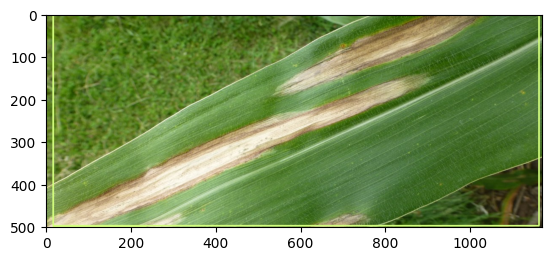

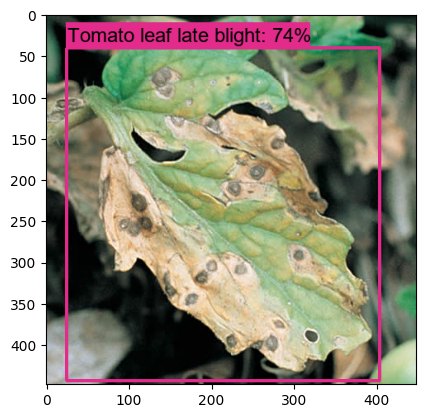

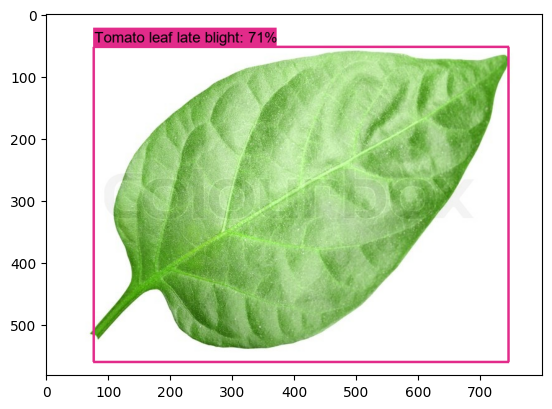

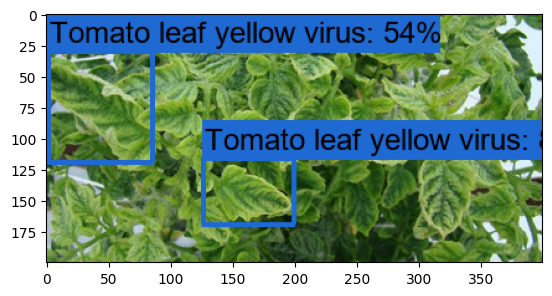

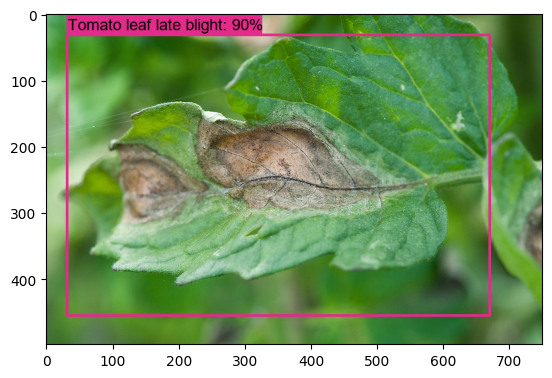

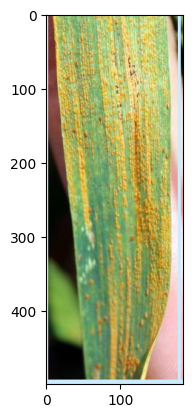

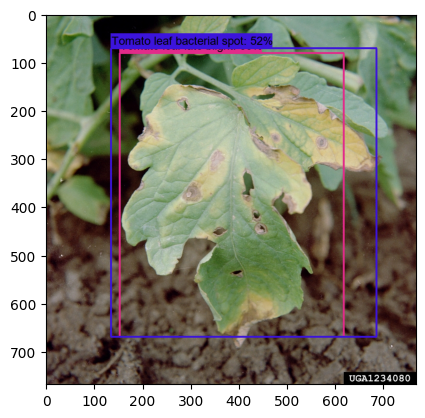

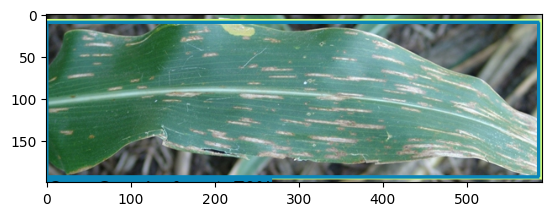

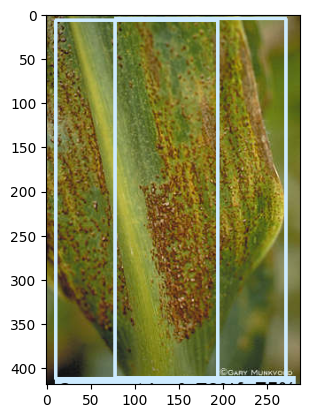

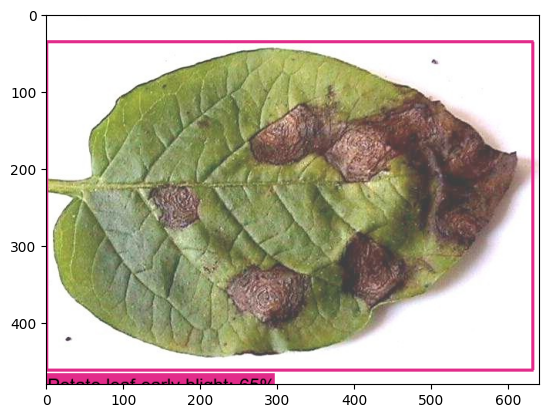

In [98]:
testfiles = os.listdir(os.path.join(paths['IMAGE_PATH'], 'TEST'))
testfiles = [t for t in testfiles if t[-4:]=='.jpg']

for f in testfiles[20:30]:
    predict_one_image(os.path.join(paths['IMAGE_PATH'], 'TEST', f))

# 10. Freezing the Graph / export protobuf

In [121]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [122]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [123]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [ ]:
!{command}

docker run -p 8500:8500 -p 8501:8501 --mount type=bind,source=D:/code/_projects/_practice/TFODCourse-main/Tensorflow/workspace/savedmodels,target=/models/plantdoc -e MODEL_NAME=plantdoc -t tensorflow/serving:2.8.0

- To check if saved model can be deployed in tf serving. apparently there is an issue listed below:

## tmp. (Save model as protobuf)(apparently bug in current exporter.py)(I've not looked into it yet)

- ref: https://medium.com/innovation-machine/deploying-object-detection-model-with-tensorflow-serving-7f12ee59b036
- "Checkpoint files can be used for inference directly or we can use freeze_graph.py script to convert the model into a frozen graph consisting of the model architecture and weights in one file. This is useful for testing purposes on your local machine but not suitable for a production environment. To create models ready for serving, we will tweak the exporter.py file available on the object detection API Github. The original script available on the repo does not save the Variables that are required for serving. Use the following exporter.py script instead of the original TensorFlow one."

In [ ]:
%%writefile modelexporter.py
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Functions to export object detection inference graph."""
import logging
import os
import tempfile
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python import pywrap_tensorflow
from tensorflow.python.client import session
from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.training import saver as saver_lib
from object_detection.builders import model_builder
from object_detection.core import standard_fields as fields
from object_detection.data_decoders import tf_example_decoder

slim = tf.contrib.slim


# TODO: Replace with freeze_graph.freeze_graph_with_def_protos when
# newer version of Tensorflow becomes more common.
def freeze_graph_with_def_protos(
    input_graph_def,
    input_saver_def,
    input_checkpoint,
    output_node_names,
    restore_op_name,
    filename_tensor_name,
    clear_devices,
    initializer_nodes,
    optimize_graph=True,
    variable_names_blacklist=''):
  """Converts all variables in a graph and checkpoint into constants."""
  del restore_op_name, filename_tensor_name  # Unused by updated loading code.

  # 'input_checkpoint' may be a prefix if we're using Saver V2 format
  if not saver_lib.checkpoint_exists(input_checkpoint):
    raise ValueError(
        'Input checkpoint "' + input_checkpoint + '" does not exist!')

  if not output_node_names:
    raise ValueError(
        'You must supply the name of a node to --output_node_names.')

  # Remove all the explicit device specifications for this node. This helps to
  # make the graph more portable.
  if clear_devices:
    for node in input_graph_def.node:
      node.device = ''

  with tf.Graph().as_default():
    tf.import_graph_def(input_graph_def, name='')

    if optimize_graph:
      logging.info('Graph Rewriter optimizations enabled')
      rewrite_options = rewriter_config_pb2.RewriterConfig(
          optimize_tensor_layout=True)
      rewrite_options.optimizers.append('pruning')
      rewrite_options.optimizers.append('constfold')
      rewrite_options.optimizers.append('layout')
      graph_options = tf.GraphOptions(
          rewrite_options=rewrite_options, infer_shapes=True)
    else:
      logging.info('Graph Rewriter optimizations disabled')
      graph_options = tf.GraphOptions()
    config = tf.ConfigProto(graph_options=graph_options)
    with session.Session(config=config) as sess:
      if input_saver_def:
        saver = saver_lib.Saver(saver_def=input_saver_def)
        saver.restore(sess, input_checkpoint)
      else:
        var_list = {}
        reader = pywrap_tensorflow.NewCheckpointReader(input_checkpoint)
        var_to_shape_map = reader.get_variable_to_shape_map()
        for key in var_to_shape_map:
          try:
            tensor = sess.graph.get_tensor_by_name(key + ':0')
          except KeyError:
            # This tensor doesn't exist in the graph (for example it's
            # 'global_step' or a similar housekeeping element) so skip it.
            continue
          var_list[key] = tensor
        saver = saver_lib.Saver(var_list=var_list)
        saver.restore(sess, input_checkpoint)
        if initializer_nodes:
          sess.run(initializer_nodes)

      variable_names_blacklist = (variable_names_blacklist.split(',') if
                                  variable_names_blacklist else None)
      output_graph_def = graph_util.convert_variables_to_constants(
          sess,
          input_graph_def,
          output_node_names.split(','),
          variable_names_blacklist=variable_names_blacklist)

  return output_graph_def


def replace_variable_values_with_moving_averages(graph,
                                                 current_checkpoint_file,
                                                 new_checkpoint_file):
  """Replaces variable values in the checkpoint with their moving averages.
  If the current checkpoint has shadow variables maintaining moving averages of
  the variables defined in the graph, this function generates a new checkpoint
  where the variables contain the values of their moving averages.
  Args:
    graph: a tf.Graph object.
    current_checkpoint_file: a checkpoint containing both original variables and
      their moving averages.
    new_checkpoint_file: file path to write a new checkpoint.
  """
  with graph.as_default():
    variable_averages = tf.train.ExponentialMovingAverage(0.0)
    ema_variables_to_restore = variable_averages.variables_to_restore()
    with tf.Session() as sess:
      read_saver = tf.train.Saver(ema_variables_to_restore)
      read_saver.restore(sess, current_checkpoint_file)
      write_saver = tf.train.Saver()
      write_saver.save(sess, new_checkpoint_file)


def _image_tensor_input_placeholder(input_shape=None):
  """Returns input placeholder and a 4-D uint8 image tensor."""
  if input_shape is None:
    input_shape = (None, None, None, 3)
  input_tensor = tf.placeholder(
      dtype=tf.uint8, shape=input_shape, name='image_tensor')
  return input_tensor, input_tensor


def _tf_example_input_placeholder():
  """Returns input that accepts a batch of strings with tf examples.
  Returns:
    a tuple of input placeholder and the output decoded images.
  """
  batch_tf_example_placeholder = tf.placeholder(
      tf.string, shape=[None], name='tf_example')
  def decode(tf_example_string_tensor):
    tensor_dict = tf_example_decoder.TfExampleDecoder().decode(
        tf_example_string_tensor)
    image_tensor = tensor_dict[fields.InputDataFields.image]
    return image_tensor
  return (batch_tf_example_placeholder,
          tf.map_fn(decode,
                    elems=batch_tf_example_placeholder,
                    dtype=tf.uint8,
                    parallel_iterations=32,
                    back_prop=False))


def _encoded_image_string_tensor_input_placeholder():
  """Returns input that accepts a batch of PNG or JPEG strings.
  Returns:
    a tuple of input placeholder and the output decoded images.
  """
  batch_image_str_placeholder = tf.placeholder(
      dtype=tf.string,
      shape=[None],
      name='encoded_image_string_tensor')
  def decode(encoded_image_string_tensor):
    image_tensor = tf.image.decode_image(encoded_image_string_tensor,
                                         channels=3)
    image_tensor.set_shape((None, None, 3))
    return image_tensor
  return (batch_image_str_placeholder,
          tf.map_fn(
              decode,
              elems=batch_image_str_placeholder,
              dtype=tf.uint8,
              parallel_iterations=32,
              back_prop=False))


input_placeholder_fn_map = {
    'image_tensor': _image_tensor_input_placeholder,
    'encoded_image_string_tensor':
    _encoded_image_string_tensor_input_placeholder,
    'tf_example': _tf_example_input_placeholder,
}


def _add_output_tensor_nodes(postprocessed_tensors,
                             output_collection_name='inference_op'):
  """Adds output nodes for detection boxes and scores.
  Adds the following nodes for output tensors -
    * num_detections: float32 tensor of shape [batch_size].
    * detection_boxes: float32 tensor of shape [batch_size, num_boxes, 4]
      containing detected boxes.
    * detection_scores: float32 tensor of shape [batch_size, num_boxes]
      containing scores for the detected boxes.
    * detection_classes: float32 tensor of shape [batch_size, num_boxes]
      containing class predictions for the detected boxes.
    * detection_masks: (Optional) float32 tensor of shape
      [batch_size, num_boxes, mask_height, mask_width] containing masks for each
      detection box.
  Args:
    postprocessed_tensors: a dictionary containing the following fields
      'detection_boxes': [batch, max_detections, 4]
      'detection_scores': [batch, max_detections]
      'detection_classes': [batch, max_detections]
      'detection_masks': [batch, max_detections, mask_height, mask_width]
        (optional).
      'num_detections': [batch]
    output_collection_name: Name of collection to add output tensors to.
  Returns:
    A tensor dict containing the added output tensor nodes.
  """
  label_id_offset = 1
  boxes = postprocessed_tensors.get('detection_boxes')
  scores = postprocessed_tensors.get('detection_scores')
  classes = postprocessed_tensors.get('detection_classes') + label_id_offset
  masks = postprocessed_tensors.get('detection_masks')
  num_detections = postprocessed_tensors.get('num_detections')
  outputs = {}
  outputs['detection_boxes'] = tf.identity(boxes, name='detection_boxes')
  outputs['detection_scores'] = tf.identity(scores, name='detection_scores')
  outputs['detection_classes'] = tf.identity(classes, name='detection_classes')
  outputs['num_detections'] = tf.identity(num_detections, name='num_detections')
  if masks is not None:
    outputs['detection_masks'] = tf.identity(masks, name='detection_masks')
  for output_key in outputs:
    tf.add_to_collection(output_collection_name, outputs[output_key])
  if masks is not None:
    tf.add_to_collection(output_collection_name, outputs['detection_masks'])
  return outputs


# def _write_frozen_graph(frozen_graph_path, frozen_graph_def):
#   """Writes frozen graph to disk.
#
#   Args:
#     frozen_graph_path: Path to write inference graph.
#     frozen_graph_def: tf.GraphDef holding frozen graph.
#   """
#   with gfile.GFile(frozen_graph_path, 'wb') as f:
#     f.write(frozen_graph_def.SerializeToString())
#   logging.info('%d ops in the final graph.', len(frozen_graph_def.node))

def _write_saved_model(saved_model_path,
                       trained_checkpoint_prefix,
                       inputs,
                       outputs):
  """Writes SavedModel to disk.
  Args:
    saved_model_path: Path to write SavedModel.
    trained_checkpoint_prefix: path to trained_checkpoint_prefix.
    inputs: The input image tensor to use for detection.
    outputs: A tensor dictionary containing the outputs of a DetectionModel.
  """
  saver = tf.train.Saver()
  with session.Session() as sess:
    saver.restore(sess, trained_checkpoint_prefix)
    builder = tf.saved_model.builder.SavedModelBuilder(saved_model_path)

    tensor_info_inputs = {
          'inputs': tf.saved_model.utils.build_tensor_info(inputs)}
    tensor_info_outputs = {}
    for k, v in outputs.items():
      tensor_info_outputs[k] = tf.saved_model.utils.build_tensor_info(v)

    detection_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
              inputs=tensor_info_inputs,
              outputs=tensor_info_outputs,
              method_name=signature_constants.PREDICT_METHOD_NAME))

    builder.add_meta_graph_and_variables(
          sess, [tf.saved_model.tag_constants.SERVING],
          signature_def_map={
              'detection_signature':
                  detection_signature,
              signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                  detection_signature,
          },
      )
    builder.save()

def _export_inference_graph(input_type,
                            detection_model,
                            use_moving_averages,
                            trained_checkpoint_prefix,
                            output_directory,
                            additional_output_tensor_names=None,
                            input_shape=None,
                            optimize_graph=True,
                            output_collection_name='inference_op'):
  """Export helper."""
  #tf.gfile.MakeDirs(output_directory)
  #frozen_graph_path = os.path.join(output_directory,
  #                                 'frozen_inference_graph.pb')
  #saved_model_path = os.path.join(output_directory, 'saved_model')
  saved_model_path = output_directory

  if input_type not in input_placeholder_fn_map:
    raise ValueError('Unknown input type: {}'.format(input_type))
  placeholder_args = {}
  if input_shape is not None:
    if input_type != 'image_tensor':
      raise ValueError('Can only specify input shape for `image_tensor` '
                       'inputs.')
    placeholder_args['input_shape'] = input_shape
  placeholder_tensor, input_tensors = input_placeholder_fn_map[input_type](
      **placeholder_args)
  inputs = tf.to_float(input_tensors)
  preprocessed_inputs = detection_model.preprocess(inputs)
  output_tensors = detection_model.predict(preprocessed_inputs)
  postprocessed_tensors = detection_model.postprocess(output_tensors)
  outputs = _add_output_tensor_nodes(postprocessed_tensors,
                                     output_collection_name)
  # Add global step to the graph.
  slim.get_or_create_global_step()

  if use_moving_averages:
    temp_checkpoint_file = tempfile.NamedTemporaryFile()
    replace_variable_values_with_moving_averages(
        tf.get_default_graph(), trained_checkpoint_prefix,
        temp_checkpoint_file.name)
    checkpoint_to_use = temp_checkpoint_file.name
  else:
    checkpoint_to_use = trained_checkpoint_prefix

  saver = tf.train.Saver()
  input_saver_def = saver.as_saver_def()

  if additional_output_tensor_names is not None:
    output_node_names = ','.join(outputs.keys()+additional_output_tensor_names)
  else:
    output_node_names = ','.join(outputs.keys())

  frozen_graph_def = freeze_graph_with_def_protos(
      input_graph_def=tf.get_default_graph().as_graph_def(),
      input_saver_def=input_saver_def,
      input_checkpoint=checkpoint_to_use,
      output_node_names=output_node_names,
      restore_op_name='save/restore_all',
      filename_tensor_name='save/Const:0',
      clear_devices=True,
      optimize_graph=optimize_graph,
      initializer_nodes='')
  #_write_frozen_graph(frozen_graph_path, frozen_graph_def)
  _write_saved_model(saved_model_path, trained_checkpoint_prefix,
                     placeholder_tensor, outputs)


def export_inference_graph(input_type,
                           pipeline_config,
                           trained_checkpoint_prefix,
                           output_directory,
                           input_shape=None,
                           optimize_graph=True,
                           output_collection_name='inference_op',
                           additional_output_tensor_names=None):
  """Exports inference graph for the model specified in the pipeline config.
  Args:
    input_type: Type of input for the graph. Can be one of [`image_tensor`,
      `tf_example`].
    pipeline_config: pipeline_pb2.TrainAndEvalPipelineConfig proto.
    trained_checkpoint_prefix: Path to the trained checkpoint file.
    output_directory: Path to write outputs.
    input_shape: Sets a fixed shape for an `image_tensor` input. If not
      specified, will default to [None, None, None, 3].
    optimize_graph: Whether to optimize graph using Grappler.
    output_collection_name: Name of collection to add output tensors to.
      If None, does not add output tensors to a collection.
    additional_output_tensor_names: list of additional output
    tensors to include in the frozen graph.
  """
  detection_model = model_builder.build(pipeline_config.model,
                                        is_training=False)
  _export_inference_graph(input_type, detection_model,
                          pipeline_config.eval_config.use_moving_averages,
                          trained_checkpoint_prefix,
                          output_directory, additional_output_tensor_names,
                          input_shape, optimize_graph, output_collection_name)

Writing modelexporter.py


In [ ]:
import sys
sys.path.append(os.getcwd())
# from modelexporter import export_inference_graph
import modelexporter

ModuleNotFoundError: No module named 'modelexporter'

In [ ]:
import tensorflow as tf
impo

# Assuming object detection API is available for use
from object_detection.utils.config_util import create_pipeline_proto_from_configs
from object_detection.utils.config_util import get_configs_from_pipeline_file
import object_detection.exporter

# Configuration for model to be exported
config_pathname = files['PIPELINE_CONFIG']

# Input checkpoint for the model to be exported
# Path to the directory which consists of the saved model on disk (see above)
trained_model_dir = paths['CHECKPOINT_PATH'] # os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')

# Create proto from model confguration
configs = get_configs_from_pipeline_file(config_pathname)
pipeline_proto = create_pipeline_proto_from_configs(configs=configs)

# Read .ckpt and .meta files from model directory
checkpoint = tf.train.get_checkpoint_state(trained_model_dir)
input_checkpoint = checkpoint.model_checkpoint_path

# Model Version
model_version_id = 'v1'

# Output Directory
output_directory = './Tensorflow/workspace/savedmodels/' + str(model_version_id)

# Export model for serving
object_detection.exporter.export_inference_graph(input_type='image_tensor',pipeline_config=pipeline_proto,trained_checkpoint_prefix=input_checkpoint,output_directory=output_directory)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
detection_model

In [ ]:
import time

def export_model(model, base_path='./Tensorflow/workspace/savedmodels/'):
    path = os.path.join(base_path, str(int(time.time())))
    tf.saved_model.save(model, path)

export_model(ckpt)

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')